<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


<h1>Batch Normalization with the MNIST Dataset</h1>



<h3>Objective for this Notebook<h3>    
<h5> 1. Define Several Neural Networks, Criterion function, Optimizer.</h5>
<h5> 2. Train Neural Network using Batch Normalization and no Batch Normalization </h5>   



<h2>Table of Contents</h2>
In this lab, you will build a Neural Network using Batch Normalization and compare it to a Neural Network that does not use Batch Normalization. You will use the MNIST dataset to test your network. 

<ul>
<li><a href="#Preparation">Preparation</a></li>    
<li><a href="#Train_Func">Neural Network Module and Training Function</a></li>
<li><a href="#Makeup_Data">Make Some Data</a></li>
<li><a href="#NN">Define Several Neural Networks, Criterion function, Optimizer</a></li>
<li><a href="#Train">Train Neural Network using Batch Normalization and no Batch Normalization</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>
</div>

<hr>


<a name="Preparation"><h2>Preparation</h2></a>


We'll need the following libraries:  


In [ ]:
%%time
%pip install pandas numpy matplotlib
%pip install torch==2.8.0+cpu torchvision==0.23.0+cpu torchaudio==2.8.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu

In [1]:
# These are the libraries will be used for this lab.

# Using the following line code to install the torchvision library
# !mamba install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(0)

<!--Empty Space for separating topics-->


<a name="Train_Func"><h2 id="Train_Func">Neural Network Module and Training Function</h2></a>


Define the neural network module or class 


 Neural Network Module with two hidden layers using Batch Normalization


In [2]:
# Define the Neural Network Model using Batch Normalization

class NetBatchNorm(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super(NetBatchNorm, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)
        
    # Prediction
    def forward(self, x):
        x = self.bn1(torch.sigmoid(self.linear1(x)))
        x = self.bn2(torch.sigmoid(self.linear2(x)))
        x = self.linear3(x)
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        out = []
        z1 = self.bn1(self.linear1(x))
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.bn2(self.linear2(a1))
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out

Neural Network Module with two hidden layers with out Batch Normalization


In [3]:
# Class Net for Neural Network Model

class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):

        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
    
    # Prediction
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        out = []
        z1 = self.linear1(x)
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.linear2(a1)
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out 


Define a function to train the model. In this case the function returns a Python dictionary to store the training loss and accuracy on the validation data 


In [4]:
# Define the function to train model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss':[], 'validation_accuracy':[]}  

    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())
            
        correct = 0
        for x, y in validation_loader:
            model.eval()
            yhat = model(x.view(-1, 28 * 28))
            _, label = torch.max(yhat, 1)
            correct += (label == y).sum().item()
            
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    
    return useful_stuff

<!--Empty Space for separating topics-->


<a name="Makeup_Data"><h2 id="Makeup_Data">Make Some Data</h2></a>


Load the training dataset by setting the parameters <code>train </code> to <code>True</code> and convert it to a tensor  by placing a transform object int the argument <code>transform</code>


In [5]:
# load the train dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

Load the validating dataset by setting the parameters train  <code>False</code> and convert it to a tensor by placing a transform object into the argument <code>transform</code>


In [6]:
# load the train dataset

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

create the training-data loader and the validation-data loader object 


In [7]:
# Create Data Loader for both train and validating

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

<a id="ref3"></a>
<a name="NN"><h2 align=center>Define Neural Network, Criterion function, Optimizer and Train the  Model  </h2></a>


Create the criterion function  


In [8]:
# Create the criterion function

criterion = nn.CrossEntropyLoss()

Variables for Neural Network Shape <code> hidden_dim</code> used for number of neurons in both hidden layers.


In [9]:
# Set the parameters

input_dim = 28 * 28
hidden_dim = 100
output_dim = 10

<!--Empty Space for separating topics-->


<a name="Train"><h2 id="Train">Train Neural Network using Batch Normalization and no Batch Normalization </h2></a>


Train Neural Network using  Batch Normalization :


In [10]:
# Create model, optimizer and train the model

model_norm  = NetBatchNorm(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model_norm.parameters(), lr = 0.1)
training_results_Norm=train(model_norm , criterion, train_loader, validation_loader, optimizer, epochs=5)

Train Neural Network with no Batch Normalization:


In [11]:
# Create model without Batch Normalization, optimizer and train the model

model = Net(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=5)

<a name="Result"><h2 id="Result">Analyze Results</h2></a>


Compare the histograms of the activation for the first layer of the first sample, for both models.


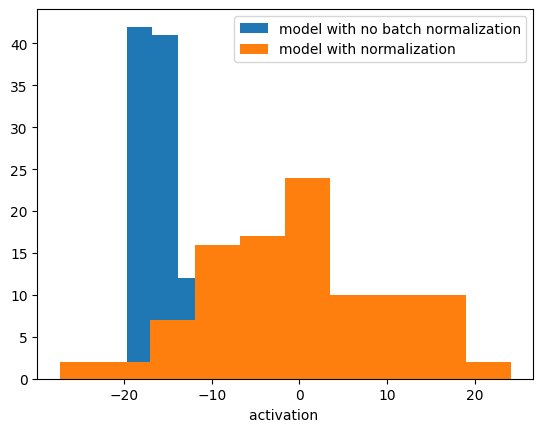

In [12]:
model.eval()
model_norm.eval()
out=model.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out[2],label='model with no batch normalization' )
out_norm=model_norm.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out_norm[2],label='model with normalization')
plt.xlabel("activation ")
plt.legend()
plt.show()

<!--Empty Space for separating topics-->


We see the activations with Batch Normalization are zero centred and have a smaller variance.


Compare the training loss for each iteration


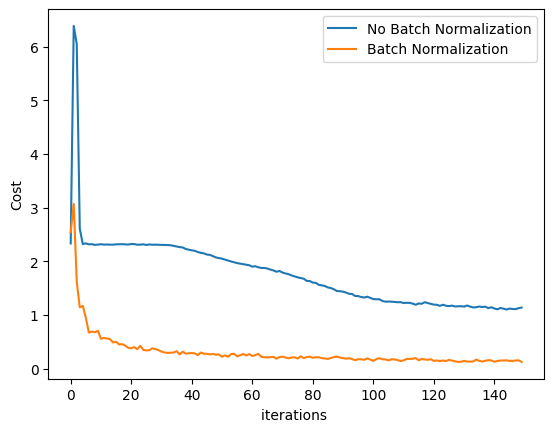

In [13]:
# Plot the diagram to show the loss

plt.plot(training_results['training_loss'], label='No Batch Normalization')
plt.plot(training_results_Norm['training_loss'], label='Batch Normalization')
plt.ylabel('Cost')
plt.xlabel('iterations ')   
plt.legend()
plt.show()

Compare the validating accuracy for each iteration


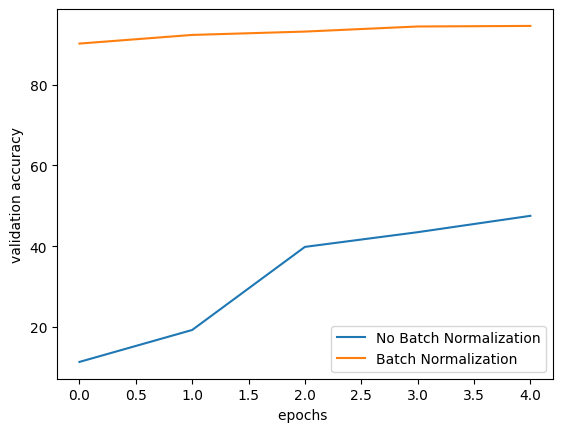

In [14]:
# Plot the diagram to show the accuracy

plt.plot(training_results['validation_accuracy'],label='No Batch Normalization')
plt.plot(training_results_Norm['validation_accuracy'],label='Batch Normalization')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')   
plt.legend()
plt.show()

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a> 


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-23  | 2.0  | Srishti  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>
-->

## <h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
